# **Dataset description**

This database contains a complete set of board configurations at the end of **Tic-Tac-Toe** games.

It is assumed that **x** always starts the game.

</br></br>

The task is to perform binary classification to determine whether **x** won or lost.

If **x** achieved one of the eight possible winning sequences, the result was labeled as `positive`; otherwise, it was labeled as `negative`.

</br>

This project utilises the [Tic-Tac-Toe Endgame](https://archive.ics.uci.edu/dataset/101/tic+tac+toe+endgame) dataset,
donated by David Aha in 1991, which is shared under the **[CC-BY-4.0](https://creativecommons.org/licenses/by/4.0/)** license.

</br></br>

<img src="https://github.com/CromvOrr/computational-intelligence/blob/images/icon.png?raw=true" alt="" width="450"/>

<img src="https://github.com/CromvOrr/computational-intelligence/blob/images/variables-table.png?raw=true" alt="" width="800"/>

In [36]:
%%capture --no-display
%pip install ucimlrepo
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install numpy
%pip install scikit-learn
%pip install tensorflow
%pip install minisom
%pip install optuna
%pip install plotly

In [37]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision
from tensorflow.keras.layers import Dense
from minisom import MiniSom
import optuna
import warnings
from plotly.io import show
import math
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from matplotlib.lines import Line2D

In [38]:
columns = ['top-left-square', 'top-middle-square', 'top-right-square', 'middle-left-square', 'middle-middle-square',
           'middle-right-square', 'bottom-left-square', 'bottom-middle-square', 'bottom-right-square', 'class']

tic_tac_toe_endgame = fetch_ucirepo(id=101)
features = tic_tac_toe_endgame.data.features
targets = tic_tac_toe_endgame.data.targets
data = pd.concat([features, targets], axis=1)

In [39]:
data.head()

,top-left-square,top-middle-square,top-right-square,middle-left-square,middle-middle-square,middle-right-square,bottom-left-square,bottom-middle-square,bottom-right-square,class
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


This dataset has no missing values and contains a total of **958** records

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958 entries, 0 to 957
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   top-left-square       958 non-null    object
 1   top-middle-square     958 non-null    object
 2   top-right-square      958 non-null    object
 3   middle-left-square    958 non-null    object
 4   middle-middle-square  958 non-null    object
 5   middle-right-square   958 non-null    object
 6   bottom-left-square    958 non-null    object
 7   bottom-middle-square  958 non-null    object
 8   bottom-right-square   958 non-null    object
 9   class                 958 non-null    object
dtypes: object(10)
memory usage: 75.0+ KB


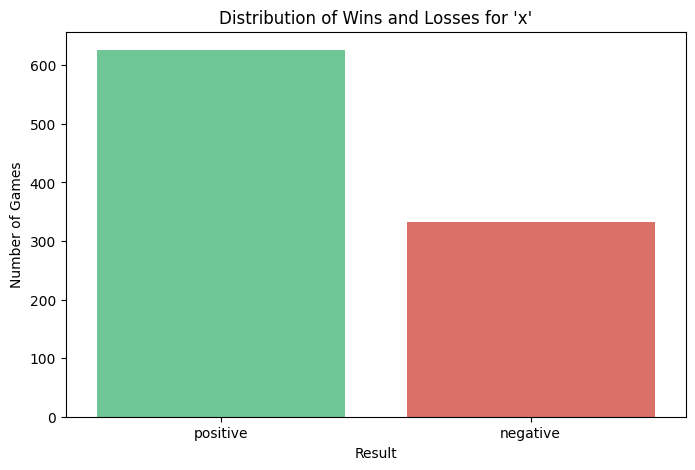

In [41]:
custom_palette = {'positive': '#60d394', 'negative': '#ee6055'}
plt.figure(figsize=(8, 5))
sns.countplot(x='class', data=data, hue='class', palette=custom_palette)
plt.title('Distribution of Wins and Losses for \'x\'')
plt.xlabel('Result')
plt.ylabel('Number of Games')
plt.show()

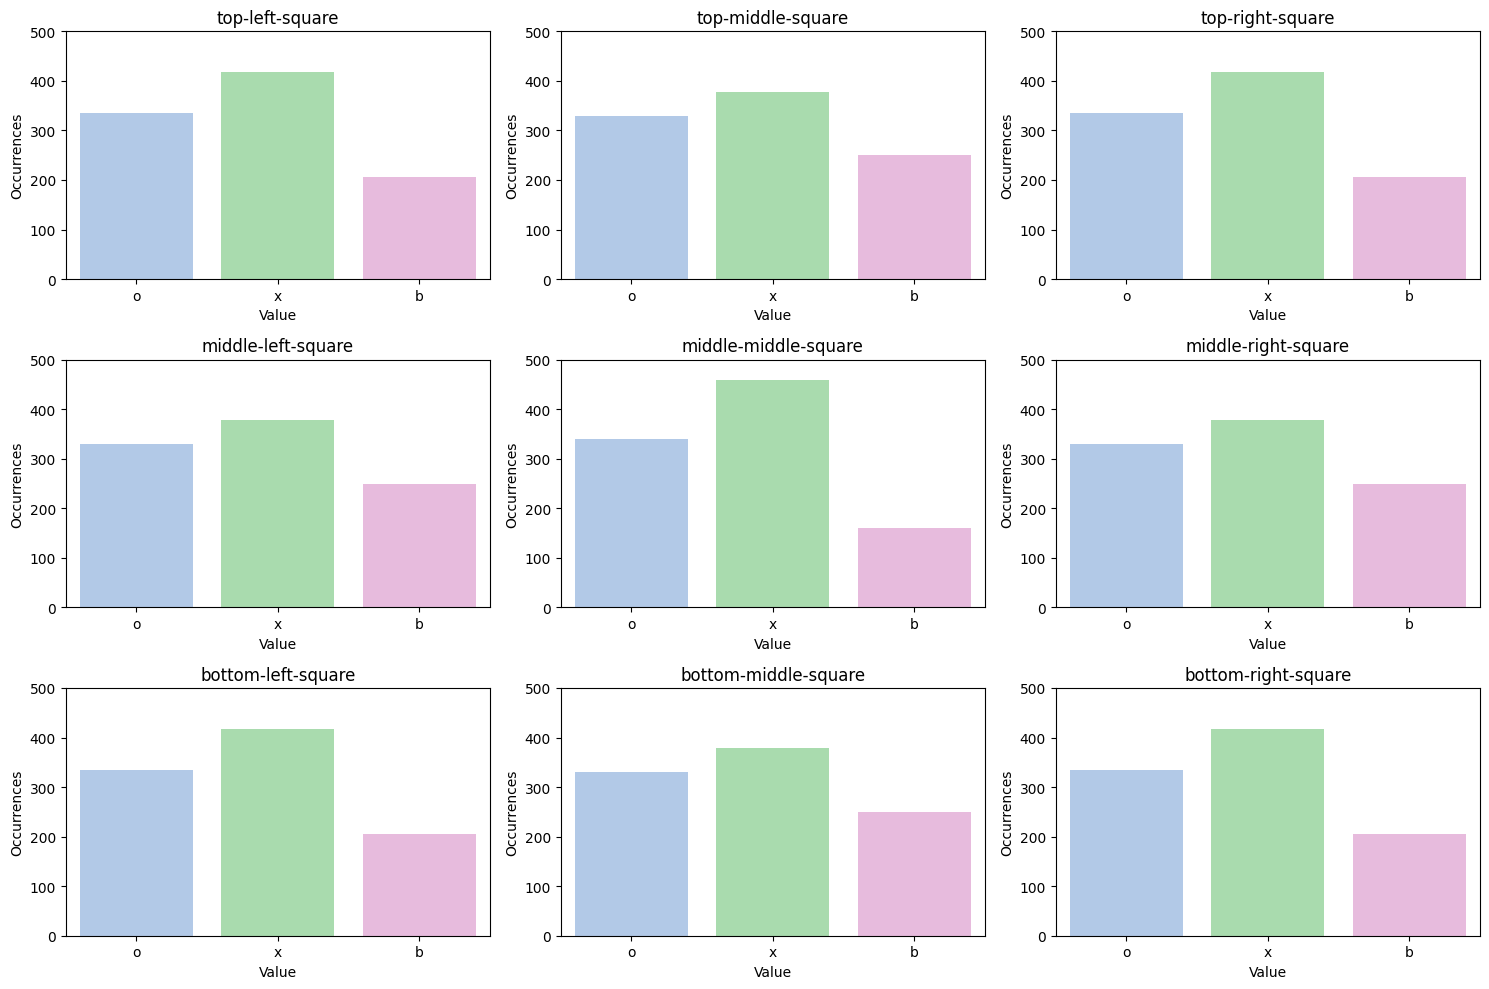

In [42]:
custom_palette = {'o': '#a9c8f0', 'x': '#a1e3a7', 'b': '#efb3e1'}
plt.figure(figsize=(15, 10))
for i, column in enumerate(columns[:-1]):
    plt.subplot(3, 3, i + 1)
    sns.countplot(data=data,
                  x=column,
                  order=['o', 'x', 'b'],
                  hue=column,
                  palette=custom_palette,
                  legend=False
                  )
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Occurrences')
    plt.ylim(0, 500)
plt.tight_layout()
plt.show()

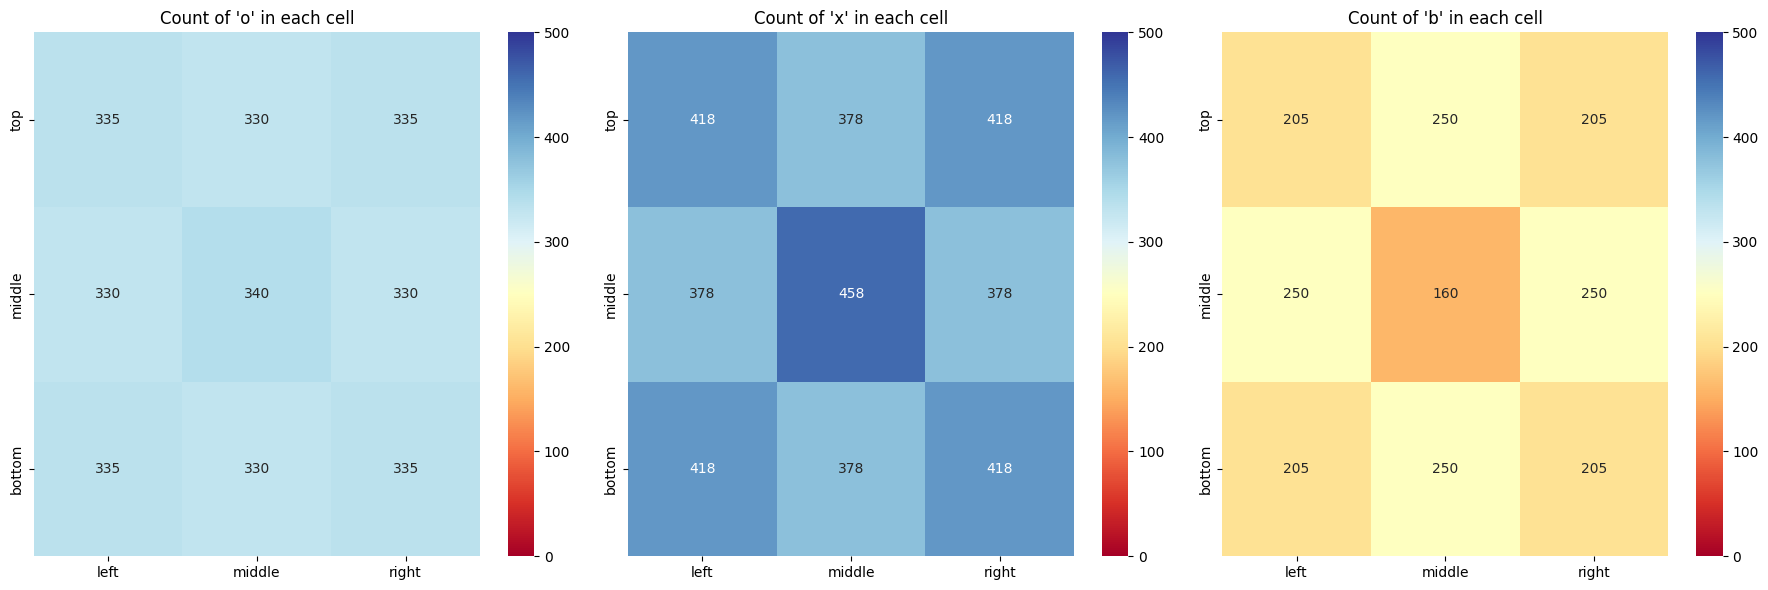

In [43]:
data_dropped = data.drop(columns=['class'])
x_labels = ['left', 'middle', 'right']
y_labels = ['top', 'middle', 'bottom']


def get_counts(char, data, data_dropped):
    counts = [data[cell].value_counts().get(char) for cell in data_dropped.columns]
    return np.array(counts).reshape(3, 3)


matrices = {
    'o': get_counts('o', data, data_dropped),
    'x': get_counts('x', data, data_dropped),
    'b': get_counts('b', data, data_dropped)
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for ax, (key, matrix) in zip(axes, matrices.items()):
    sns.heatmap(
        matrix, ax=ax, cmap='RdYlBu', cbar=True, vmin=0, vmax=500,
        xticklabels=x_labels, yticklabels=y_labels, annot=True, fmt='d'
    )
    ax.set_title(f'Count of \'{key}\' in each cell')

plt.tight_layout()
plt.show()

# **Data preparation**

We convert all categorical variables into **one-hot encoded** variables. This means that each category is transformed into new binary columns - `True` means that the observation belongs to a given category.

These variables are essential for many machine learning algorithms, as most of them require all input data to be numerical. This allows machine learning algorithms to understand categorical data.

This encoding method increases the number of neurons - thanks to it, we get more input data columns.

</br></br>

The **[train_test_split()](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.train_test_split.html)** function breaks the input data into random subsets for training and testing, while maintaining specified proportions.

Parameter `stratify` ensures that the proportions of values in created samples are the same as the proportions passed via this parameter. It also guarantees that the data used in one process does not appear in another.

</br></br>

In this case, when splitting the data into sets, it is not necessary to consider the type of network.

The reason is simple - breaking the data into two (or more) parts, either randomly or in a controlled manner, is unrelated to the model architecture.

## FFNN

In [44]:
dummies = pd.get_dummies(data)
X_FFNN = dummies.iloc[:, :-2]       # features
Y_FFNN = dummies.iloc[:, -2:]       # targets

In [45]:
X_FFNN

,top-left-square_b,top-left-square_o,top-left-square_x,top-middle-square_b,top-middle-square_o,top-middle-square_x,top-right-square_b,top-right-square_o,top-right-square_x,middle-left-square_b,...,middle-right-square_x,bottom-left-square_b,bottom-left-square_o,bottom-left-square_x,bottom-middle-square_b,bottom-middle-square_o,bottom-middle-square_x,bottom-right-square_b,bottom-right-square_o,bottom-right-square_x
0,False,False,True,False,False,True,False,False,True,False,...,False,False,False,True,False,True,False,False,True,False
1,False,False,True,False,False,True,False,False,True,False,...,False,False,True,False,False,False,True,False,True,False
2,False,False,True,False,False,True,False,False,True,False,...,False,False,True,False,False,True,False,False,False,True
3,False,False,True,False,False,True,False,False,True,False,...,False,False,True,False,True,False,False,True,False,False
4,False,False,True,False,False,True,False,False,True,False,...,False,True,False,False,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953,False,True,False,False,False,True,False,False,True,False,...,False,False,True,False,False,False,True,False,False,True
954,False,True,False,False,False,True,False,True,False,False,...,False,False,False,True,False,True,False,False,False,True
955,False,True,False,False,False,True,False,True,False,False,...,True,False,False,True,False,True,False,False,False,True
956,False,True,False,False,False,True,False,True,False,False,...,True,False,False,True,False,True,False,False,False,True


In [46]:
Y_FFNN

,class_negative,class_positive
0,False,True
1,False,True
2,False,True
3,False,True
4,False,True
...,...,...
953,True,False
954,True,False
955,True,False
956,True,False


In [47]:
x_ffnn_train, x_ffnn_test, y_ffnn_train, y_ffnn_test = train_test_split(X_FFNN.values, Y_FFNN.values, test_size=0.3, random_state=42, stratify=Y_FFNN)

## SOM

In [48]:
pd.set_option('future.no_silent_downcasting', True)
X_SOM = pd.get_dummies(data.iloc[:, :-1].replace(['x', 'b', 'o'], [1, 0, -1])).values       # features
Y_SOM = data.iloc[:, -1].replace('positive', 1).replace('negative', 0).values               # targets

In [49]:
X_SOM

array([[False, False,  True, ...,  True, False, False],
       [False, False,  True, ...,  True, False, False],
       [False, False,  True, ..., False, False,  True],
       ...,
       [ True, False, False, ..., False, False,  True],
       [ True, False, False, ..., False, False,  True],
       [ True, False, False, ..., False, False,  True]])

In [50]:
Y_SOM

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [51]:
x_som_train, x_som_test, y_som_train, y_som_test = train_test_split(X_SOM, Y_SOM, test_size=0.3, random_state=42, stratify=Y_SOM)

# **Network structure**

## FFNN

Initial network configuration:

- `27` neurons in input layer
- `55` neurons in hidden layer
- &nbsp;&nbsp;`2` neurons in output layer

These values were chosen because:

- There are `27` columns with independent variables
- FFNN must have at least one hidden layer, with the number of neurons being at least `2N + 1` (`N` - size of the input)
- There are `2` columns with labels

For the remaining parameters, such as:

- `epochs` - The number of complete passes through the entire training dataset during model training
- `batch_size` - The number of samples processed simultaneously before updating the model's weights
- `validation_split` - The portion of the training data used for validation to assess how well the model generalizes new data

    Default (or commonly used) values were applied.

## SOM

The Self-Organizing Map (SOM) network requires numerical input data to function correctly.
This is because the SOM algorithm performs calculations such as computing the distance between the input vector and the output vectors.

Fundamentally, SOM is an **unsupervised** learning method.
This means it primarily works on input data and does not require target variables.
However, due to the specifics of this project, the extraction of **Y** is required. This will be used later to evaluate the model's performance.

When performing classification with the SOM network, selecting appropriate hyperparameters is crucial for achieving the highest possible classification accuracy.

Let's take a look at what needs to be considered:

- Width of the SOM grid
- Height of the SOM grid
- Number of elements in the input vector
- Parameter defining the range of the neighborhood function
- Initial learning rate
- Function that determines how the learning rate decreases over time
- Function defining how distances from the active neuron affect other neurons

# **Network training**

## FFNN

To train the network, the following library functions from the **tensorflow.keras** module will be used:

- **[compile()](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile)** - Configures the model for training
- **[fit()](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)** - Trains the model for a specified number of epochs
- **[evaluate()](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate)** - Returns the value of the loss function and metric values for the model in test mode

In [52]:
def create_model(sequential, x_train, y_train, optimizer='adam', epochs=100, batch_size=32, validation_split=0.2,
                 verbose=0):
    model = sequential
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_split=validation_split,
                        verbose=verbose)
    return model, history

In [53]:
precision_metric = Precision()
def evaluate_model(model, x_test, y_test, precision_metric, verbose=0):
  test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=verbose)
  precision_metric.update_state(y_test, model.predict(x_test))
  return test_accuracy * 100, precision_metric.result().numpy() * 100

To demonstrate the process of hyperparameter selection, several functions will be tested:

- `sigmoid`
- `tanh`
- `relu`
- `softplus`
- `leaky_relu`
- `softmax`

In [54]:
activation_functions = ['sigmoid', 'tanh', 'relu', 'softplus', 'leaky_relu', 'softmax']
for function in activation_functions:
    print(f'Training with \'{function}\'...')
    ffnn_sequential = Sequential([
        Dense(27, activation=function),     # input
        Dense(55, activation=function),     # hidden
        Dense(2, activation=function)       # output
    ])
    
    ffnn_model = create_model(ffnn_sequential, x_ffnn_train, y_ffnn_train)[0]
    ffnn_accuracy, ffnn_precision = evaluate_model(ffnn_model, x_ffnn_test, y_ffnn_test, precision_metric)
    print(f'Accuracy:  {ffnn_accuracy: .3f}')
    print(f'Precision: {ffnn_precision: .3f}\n')

Training with 'sigmoid'...
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy:   98.958
Precision:  98.958

Training with 'tanh'...
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy:   26.736
Precision:  98.962

Training with 'relu'...
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy:   34.722
Precision:  98.962

Training with 'softplus'...
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy:   98.958
Precision:  98.962

Training with 'leaky_relu'...
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy:   55.208
Precision:  66.707

Training with 'softmax'...
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy:   90.278
Precision:  72.801



`Sigmoid` and `Softplus` achieved the best results in terms of accuracy and precision, indicating their suitability for the binary classification problem.

## SOM

Network training is based on the **MiniSom** library; the following functions will be used:

- **labels_map()** - Assigns labels to each neuron based on the majority class of the input data points mapped to that neuron
- **most_common()** - Returns the most common element and its frequency
- **winner()** - Finds the best-matching unit (BMU) or winning neuron for a given input vector

In [55]:
def classify(model, x_train, x_test, y_train):
    winmap = model.labels_map(x_train, y_train)
    default_class = np.sum(list(winmap.values())).most_common()[0][0]
    
    result = []
    for test in x_test:
        win_position = model.winner(test)
        if win_position in winmap:
            result.append(winmap[win_position].most_common()[0][0])
        else:
            result.append(default_class)
    return result

# **Parameter tuning**

Further optimization of the hyperparameters may lead to an improvement in **precision** and **accuracy**; the best combination of input parameters will be sought.

## FFNN

In [56]:
params = [
    'input_activation',
    'hidden_layers',
    'hidden_neurons0',
    'hidden_neurons1',
    'hidden_neurons2',
    'hidden_activation0',
    'hidden_activation1',
    'hidden_activation2',
    'output_activation',
    'optimizer',
    'epochs',
    'batch_size'
]


def tune_ffnn_params(trial, x_train=x_ffnn_train, x_test=x_ffnn_test, y_train=y_ffnn_train, y_test=y_ffnn_test,
                     activation_functions=activation_functions):
    # input
    input_activation_function = trial.suggest_categorical('input_activation', activation_functions)
    layers = [Dense(27, activation=input_activation_function)]

    # hidden
    hidden_layer_count = trial.suggest_int('hidden_layers', 1, 3)
    for n in range(hidden_layer_count):
        hidden_neuron_count = trial.suggest_categorical(f'hidden_neurons{n}', [4, 8, 16, 32, 64, 128, 256])
        hidden_activation_function = trial.suggest_categorical(f'hidden_activation{n}', activation_functions)
        layers.append(Dense(hidden_neuron_count, activation=hidden_activation_function))

    # output
    output_activation_function = trial.suggest_categorical('output_activation', activation_functions)
    layers.append(Dense(2, activation=output_activation_function))

    # compile
    model = Sequential(layers)
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'rmsprop', 'sgd'])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # train
    epochs = trial.suggest_int('epochs', 20, 150)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    validation_split = 0.2
    verbose = 0
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split,
              verbose=verbose)

    # evaluate
    correct = 0
    y_predicted = model.predict(x_test)
    total = len(y_predicted)
    for i, prediction in enumerate(y_predicted):
        if np.argmax(y_test[i]) == np.argmax(prediction):
            correct += 1

    accuracy = (correct / total) * 100
    return accuracy

In [57]:
%%capture --no-display
FFNN_TRIALS = 100
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
ffnn_study = optuna.create_study(direction='maximize')
ffnn_study.optimize(tune_ffnn_params, n_trials=FFNN_TRIALS, show_progress_bar=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [58]:
print('Best trial:')
best_ffnn_trial = ffnn_study.best_trial
print(f'\tAccuracy: {best_ffnn_trial.value: .3f}')
print(f'\tBest parameters: {best_ffnn_trial.params}')

Best trial:
	Accuracy:  98.958
	Best parameters: {'input_activation': 'sigmoid', 'hidden_layers': 1, 'hidden_neurons0': 128, 'hidden_activation0': 'tanh', 'output_activation': 'softplus', 'optimizer': 'adam', 'epochs': 95, 'batch_size': 64}


In [59]:
fig = optuna.visualization.plot_optimization_history(ffnn_study)
show(fig)

In [60]:
fig = optuna.visualization.plot_param_importances(ffnn_study, params=params)
show(fig)

In [61]:
del params[1]
fig = optuna.visualization.plot_parallel_coordinate(ffnn_study, params=params)
show(fig)

In [62]:
best_ffnn_params = best_ffnn_trial.params

ffnn_layers = [Dense(27, activation=best_ffnn_params['input_activation'])]
for n in range(best_ffnn_params['hidden_layers']):
    ffnn_hidden_neuron_count = best_ffnn_params[f'hidden_neurons{n}']
    ffnn_hidden_activation_function = best_ffnn_params[f'hidden_activation{n}']
    ffnn_layers.append(Dense(ffnn_hidden_neuron_count, activation=ffnn_hidden_activation_function))

ffnn_output_activation_function = best_ffnn_params['output_activation']
ffnn_layers.append(Dense(2, activation=ffnn_output_activation_function))
ffnn_sequential = Sequential(ffnn_layers)

ffnn_model, ffnn_history = create_model(ffnn_sequential, x_ffnn_train, y_ffnn_train,
                                        optimizer=best_ffnn_params['optimizer'], epochs=best_ffnn_params['epochs'],
                                        batch_size=best_ffnn_params['batch_size'])

ffnn_accuracy, ffnn_precision = evaluate_model(ffnn_model, x_ffnn_test, y_ffnn_test, precision_metric)
print(f'Accuracy:  {ffnn_accuracy: .3f}')
print(f'Precision: {ffnn_precision: .3f}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy:   98.958
Precision:  72.801


Since the model is retrained with parameters obtained from `best_ffnn_trial.params`, accuracy and precision may vary slightly.

## SOM

In [63]:
def test_som_params(trial, X=X_SOM, x_train=x_som_train, x_test=x_som_test, y_train=y_som_train, y_test=y_som_test):
    num_iteration = trial.suggest_int('num_iteration', 10, 1500)
    dim = trial.suggest_int('dim', 5, 100)
    sigma = trial.suggest_float('sigma', 1, 5)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1.5)
    topology = trial.suggest_categorical('topology', ['rectangular', 'hexagonal'])
    neighborhood_function = trial.suggest_categorical('neighborhood_function',
                                                      ['gaussian', 'mexican_hat', 'bubble', 'triangle'])

    runs = 10
    accuracies = []
    for _ in range(runs):
        model = MiniSom(dim, dim, X.shape[1],
                        neighborhood_function=neighborhood_function,
                        topology=topology,
                        sigma=sigma, learning_rate=learning_rate)
        model.pca_weights_init(x_train)
        model.train_random(x_train, num_iteration=num_iteration, verbose=0)

        correct = 0
        y_predicted = classify(model, x_train, x_test, y_train)
        total = len(y_predicted)
        for i, predicted in enumerate(y_predicted):
            if y_test[i] == predicted:
                correct += 1
        accuracies.append((correct / total) * 100)

    accuracy = np.sum(accuracies) / runs
    return accuracy

In [64]:
%%capture --no-display
SOM_TRIALS = 50
som_study = optuna.create_study(direction='maximize')
som_study.optimize(test_som_params, n_trials=SOM_TRIALS, show_progress_bar=True)

  0%|          | 0/50 [00:00<?, ?it/s]

In [65]:
print('Best trial:')
best_som_trial = som_study.best_trial
print(f'\tAccuracy: {best_som_trial.value: .3f}')
print(f'\tBest parameters: {best_som_trial.params}')

Best trial:
	Accuracy:  88.576
	Best parameters: {'num_iteration': 1397, 'dim': 55, 'sigma': 1.0881717564709772, 'learning_rate': 0.4449250502566837, 'topology': 'hexagonal', 'neighborhood_function': 'gaussian'}


In [66]:
fig = optuna.visualization.plot_optimization_history(som_study)
show(fig)

In [67]:
fig = optuna.visualization.plot_param_importances(som_study)
show(fig)

In [68]:
fig = optuna.visualization.plot_parallel_coordinate(som_study, params=['num_iteration', 'dim', 'sigma', 'learning_rate'])
show(fig)

In [69]:
N = data.shape[0]
M = 5 * N ** 0.5
som_width = int(math.sqrt(M))
som_height = int(M / som_width)

In [70]:
M

154.7578754054216

In [71]:
print(f'SOM width:  {som_width}')
print(f'SOM height: {som_height}')

SOM width:  12
SOM height: 12


In [72]:
def calculate(y_predicted):
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0

    for i, predicted in enumerate(y_predicted):
        if predicted == 1:
            if y_som_test[i] == 1:
                true_positive += 1      # model correctly classified a positive example as positive
            else:
                false_positive += 1     # model incorrectly classified a negative example as positive
        else:
            if y_som_test[i] == 0:
                true_negative += 1      # model correctly classified a negative example as negative
            else:
                false_negative += 1     # model incorrectly classified a positive example as negative

    accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
    precision = true_positive / (true_positive + false_positive)
    return accuracy * 100, precision * 100

In [73]:
best_som_params = best_som_trial.params

som_num_iteration = best_som_params['num_iteration']
som_sigma = best_som_params['sigma']
som_learning_rate = best_som_params['learning_rate']
som_topology = best_som_params['topology']
som_neighborhood_function = best_som_params['neighborhood_function']

som_model = MiniSom(som_width, som_height, X_SOM.shape[1], neighborhood_function=som_neighborhood_function,
                    topology=som_topology, sigma=som_sigma, learning_rate=som_learning_rate)
som_model.pca_weights_init(x_som_train)
som_model.train_random(x_som_train, num_iteration=som_num_iteration, verbose=0)

y_som_predicted = classify(som_model, x_som_train, x_som_test, y_som_train)
som_accuracy, som_precision = calculate(y_som_predicted)
print(f'Accuracy:  {som_accuracy: .3f}')
print(f'Precision: {som_precision: .3f}')

Accuracy:   84.028
Precision:  84.466


Since the model is retrained with parameters obtained from `best_som_trial.params`, accuracy and precision may vary slightly.

# **Outcomes**

## FFNN

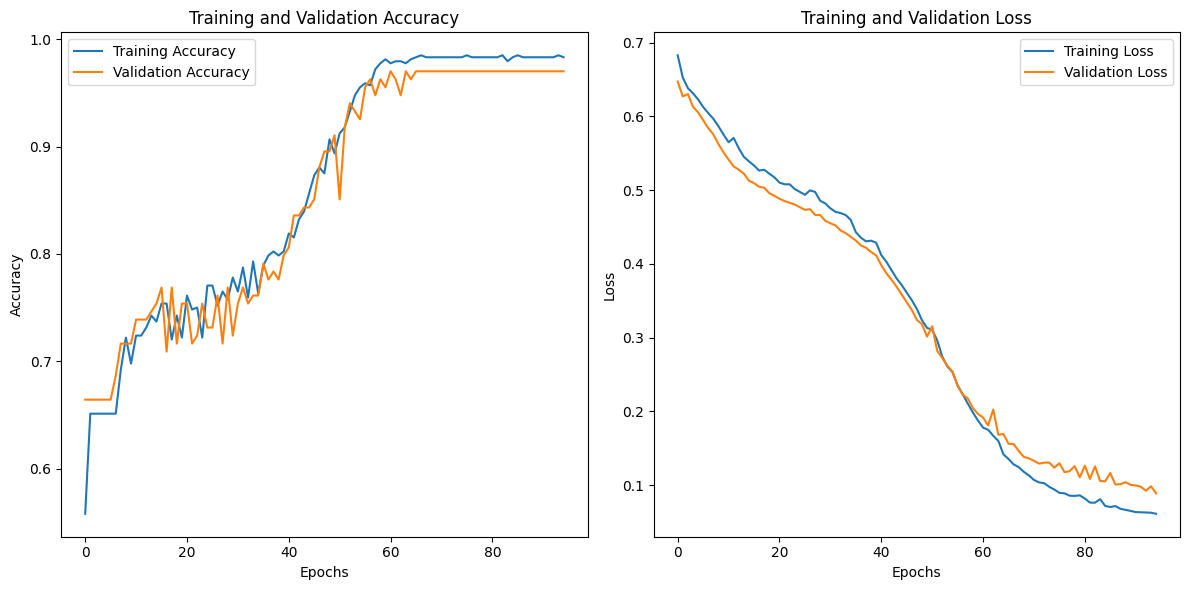

In [74]:
ffnn_history_dict = ffnn_history.history
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(ffnn_history_dict['accuracy'], label='Training Accuracy')
plt.plot(ffnn_history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ffnn_history_dict['loss'], label='Training Loss')
plt.plot(ffnn_history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


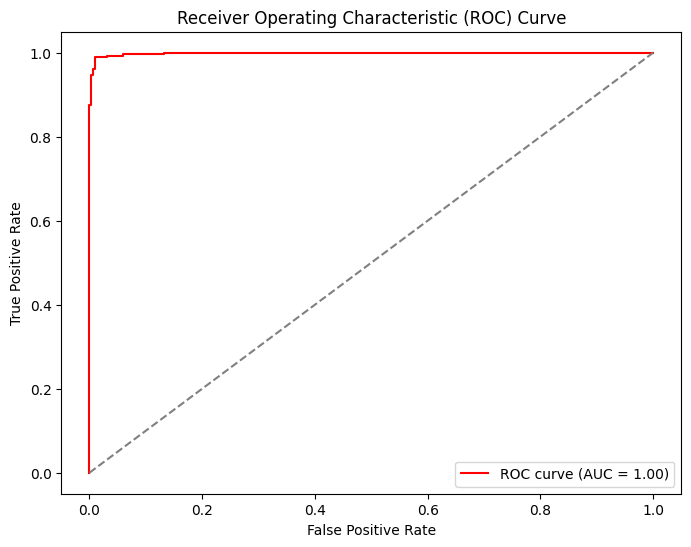

In [75]:
y_ffnn_pred = ffnn_model.predict(x_ffnn_test)
y_test_bin = label_binarize(y_ffnn_test, classes=np.unique(y_ffnn_test))
fpr, tpr, thresholds = roc_curve(y_test_bin.ravel(), y_ffnn_pred.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

## SOM

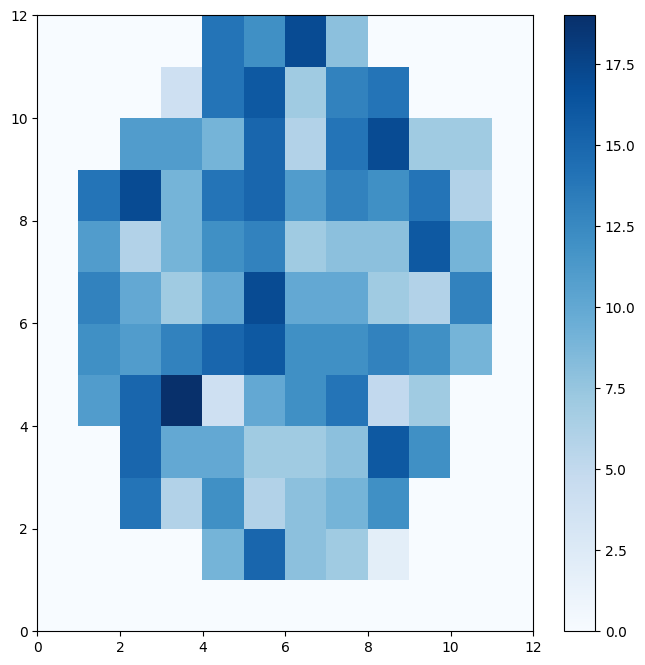

In [76]:
plt.figure(figsize=(8, 8))
frequencies = som_model.activation_response(X_SOM)
plt.pcolor(frequencies.T, cmap='Blues')
plt.colorbar()
plt.show()

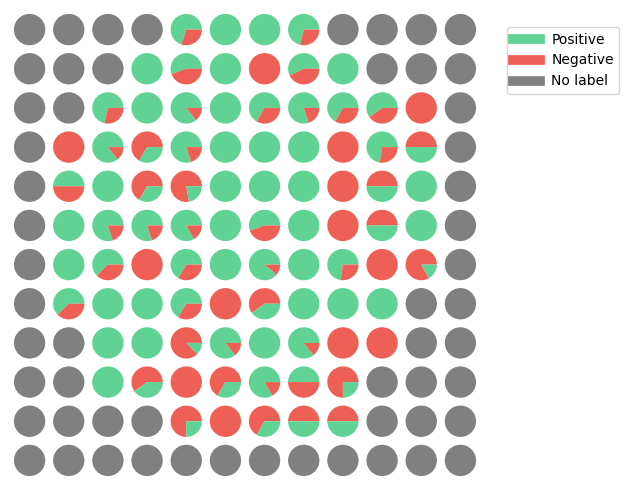

In [77]:
winmap = som_model.labels_map(x_som_train, y_som_train)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
cmap = {1: '#60d394', 0: '#ee6055'}

for x in range(som_width):
    for y in range(som_height):
        win_position = (x, y)
        if win_position in winmap:
            labels_counts = winmap[win_position].most_common()
            labels = [x[0] for x in labels_counts]
            counts = [x[1] for x in labels_counts]
            colors = [cmap[l] for l in labels]
            ax.pie(counts, labels=None, colors=colors, center=(x, y), radius=0.4)
        else:
            ax.pie([1], colors=['grey'], center=(x, y), radius=0.4)

ax.set_xlim(-0.5, som_width - 0.5)
ax.set_ylim(-0.5, som_height - 0.5)
handles = [
    Line2D([0], [0], color='#60d394', lw=7, label='Positive'),
    Line2D([0], [0], color='#ee6055', lw=7, label='Negative'),
    Line2D([0], [0], color='grey', lw=7, label='No label')
]
fig.legend(handles=handles, bbox_to_anchor=(1.01, 0.95), loc='upper left')
plt.tight_layout()
plt.show()